# Preparación del entorno
### 1.1 Configuraión inicial

In [41]:
# Instalación de paquetes necesarios
! pip install tensorflow pandas numpy matplotlib seaborn scikit-learn

# Importación de bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


### 1.2 Carga y Exploración Inicial de Datos

Forma del dataset: (545, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB
None
              price          area    bedrooms   bathrooms     stories  \
count  5.450000e+02    545.000000  545.000000  

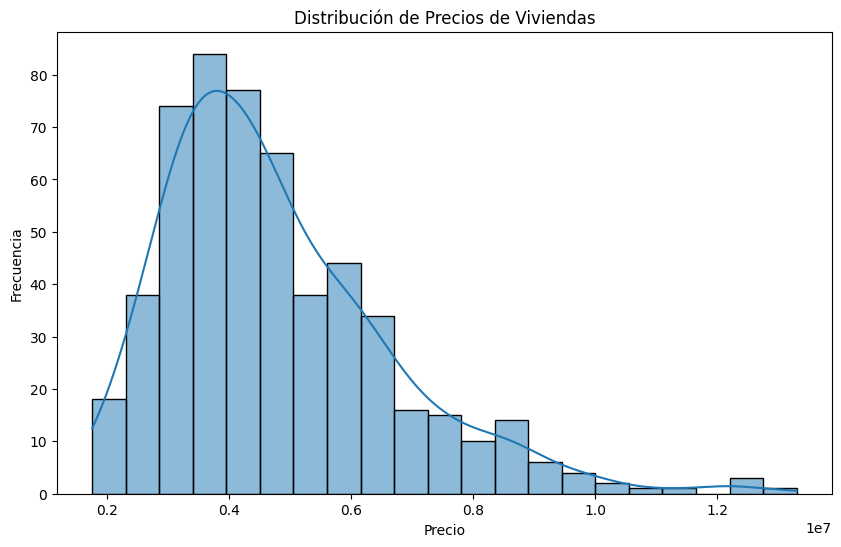

In [42]:
# Cargar el dataset
df = pd.read_csv('Housing.csv')

# Exploración inicial
print(f"Forma del dataset: {df.shape}")
print(df.info())
print(df.describe())

# Verificar valores nulos
print(f"Valores nulos por columna:\n{df.isnull().sum()}")

# Visualizar la distribución del precio
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], kde=True)
plt.title('Distribución de Precios de Viviendas')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.show()


## 2 Análisis Exploratorio de Datos (EDA)
### 2.1 Análisis de Correlaciones

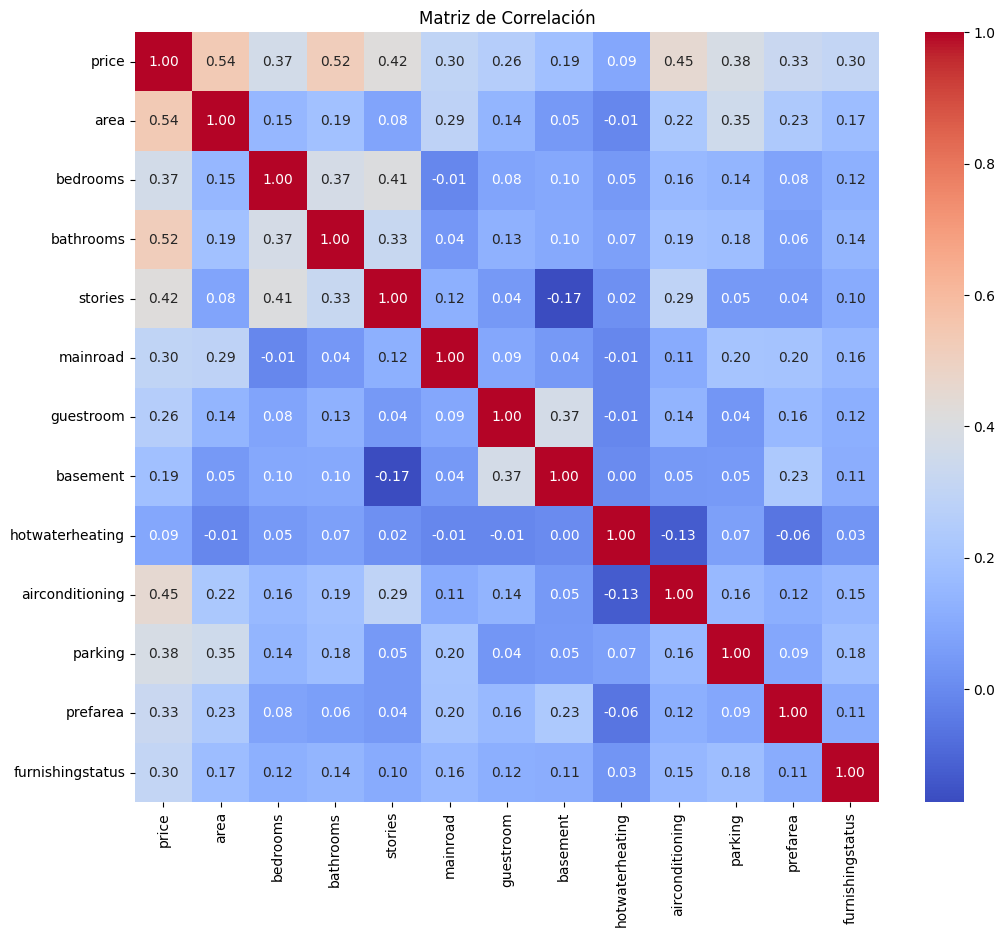

In [43]:
# Convertir variables categóricas a numéricas para análisis
df_numeric = df.copy()
categorical_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 
                    'airconditioning', 'prefarea', 'furnishingstatus']

# Codificación básica para visualización
for col in categorical_cols:
    if col != 'furnishingstatus':
        df_numeric[col] = df_numeric[col].map({'yes': 1, 'no': 0})
    else:
        df_numeric[col] = df_numeric[col].map({'unfurnished': 0, 'semi-furnished': 1, 'furnished': 2})

# Matriz de correlación
plt.figure(figsize=(12, 10))
corr_matrix = df_numeric.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación')
plt.show()


### 2.2 Análisis de Variables Categóricas

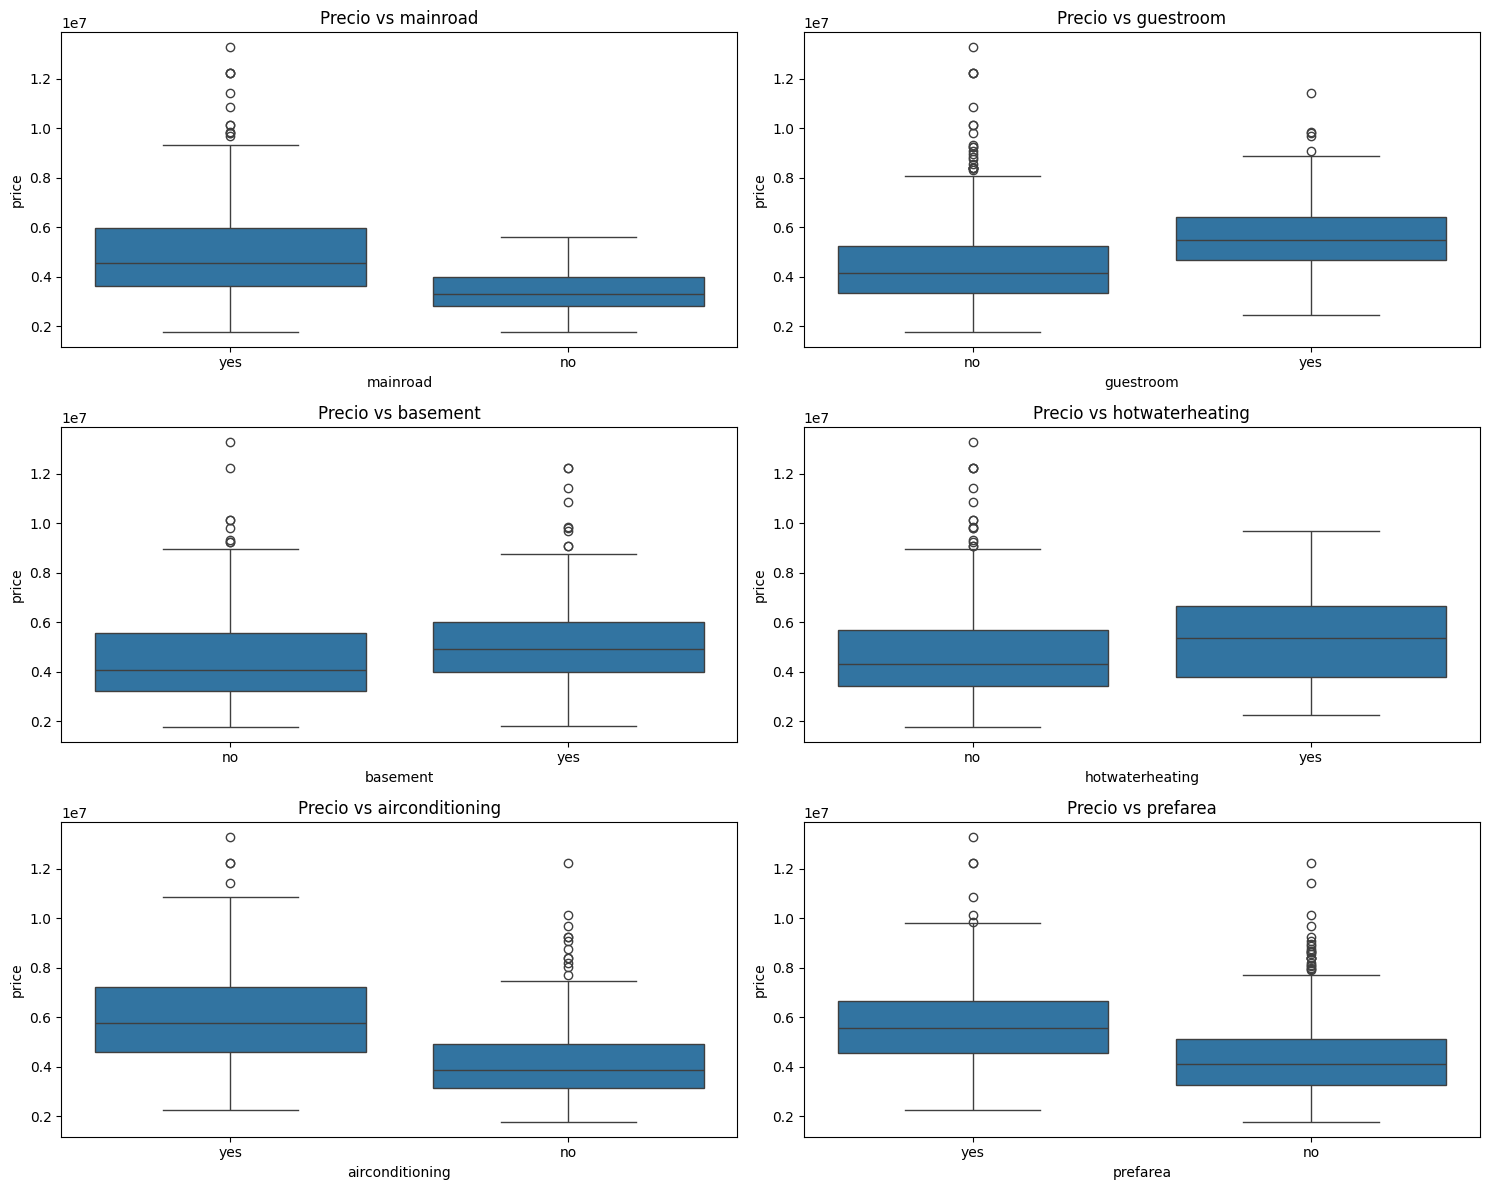

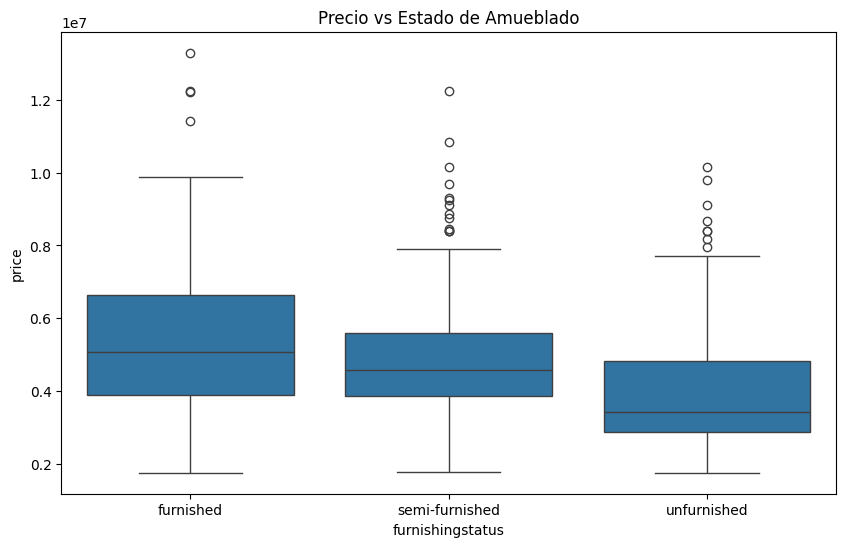

In [44]:
# Visualizar la relación entre variables categóricas y precio
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

categorical_binary = ['mainroad', 'guestroom', 'basement', 
                      'hotwaterheating', 'airconditioning', 'prefarea']

for i, cat_var in enumerate(categorical_binary):
    sns.boxplot(x=cat_var, y='price', data=df, ax=axes[i])
    axes[i].set_title(f'Precio vs {cat_var}')

plt.tight_layout()
plt.show()

# Analizar furnishingstatus
plt.figure(figsize=(10, 6))
sns.boxplot(x='furnishingstatus', y='price', data=df)
plt.title('Precio vs Estado de Amueblado')
plt.show()


### 2.3 Análisis de Variables Numéricas

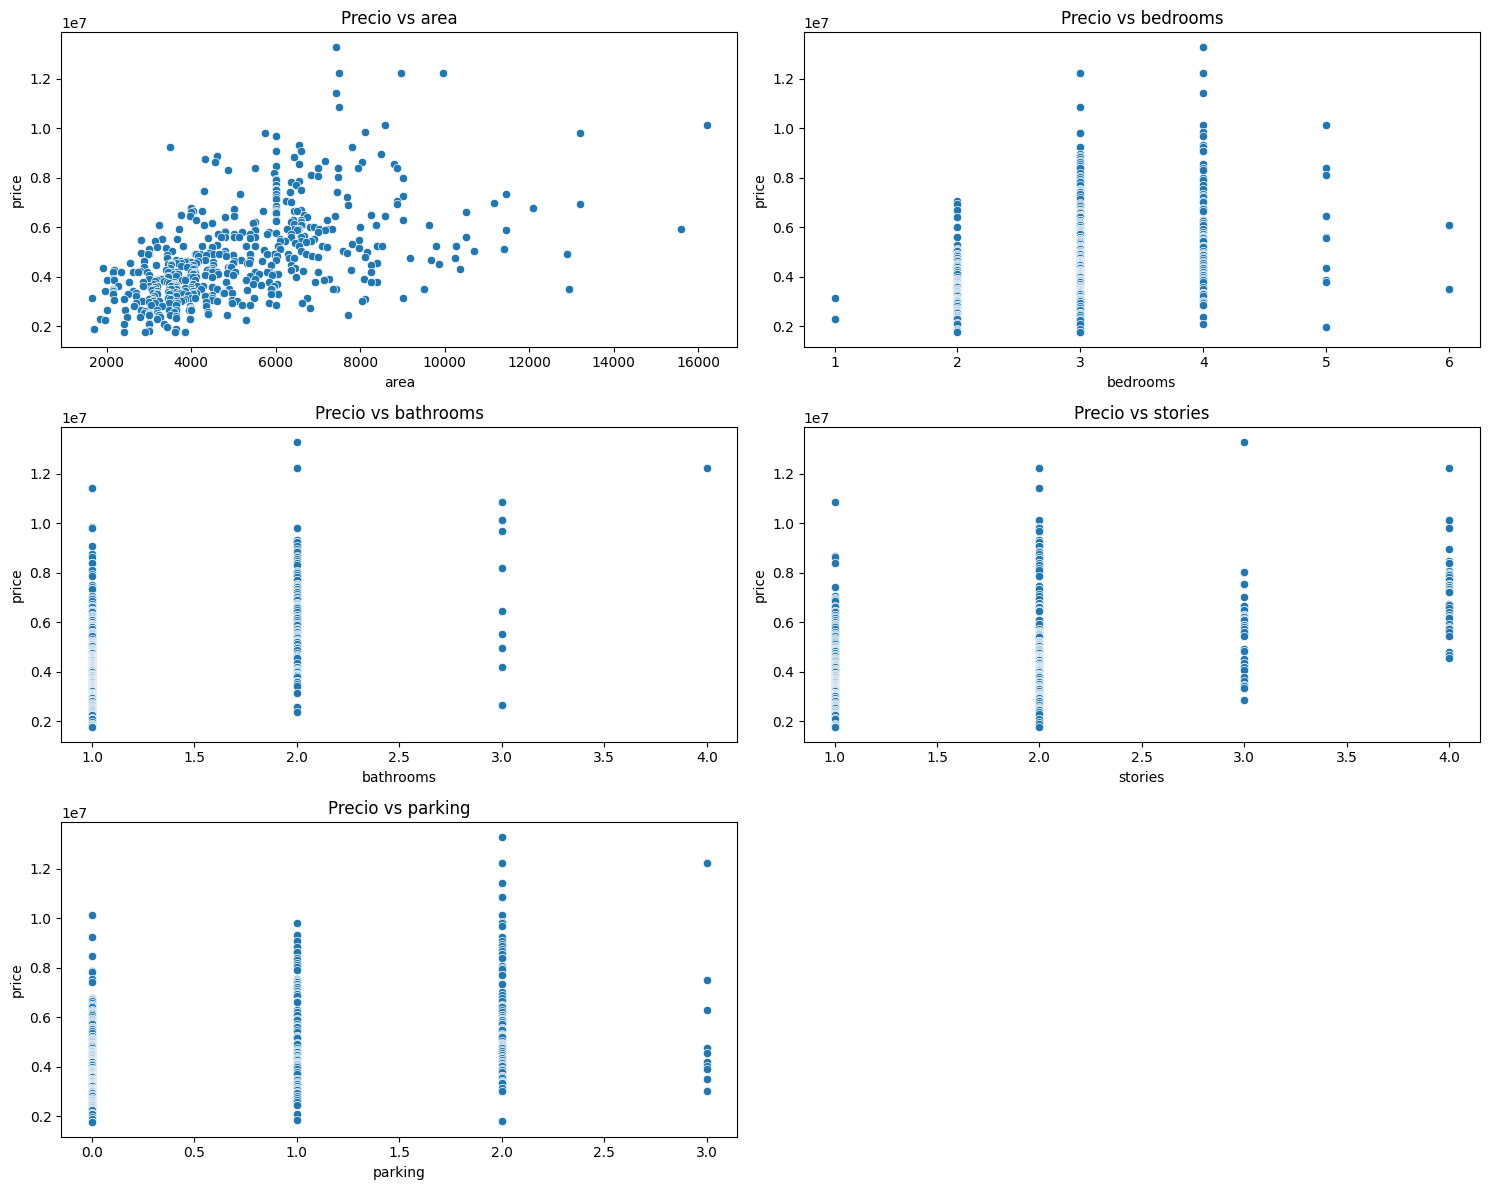

In [45]:
# Visualizar relaciones entre variables numéricas y precio
numeric_features = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']

fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

for i, feature in enumerate(numeric_features):
    if i < len(axes):
        sns.scatterplot(x=feature, y='price', data=df, ax=axes[i])
        axes[i].set_title(f'Precio vs {feature}')

# Eliminar ejes sobrantes
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## 3. Preprocesamiento de Datos
## 3.1 División del Dataset

In [46]:
# Separar características y variable objetivo
X = df.drop('price', axis=1)
y = df['price']

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### 3.2 Transformación de Variables

In [47]:
# Identificar tipos de columnas
numeric_features = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']
categorical_features = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 
                         'airconditioning', 'prefarea']
ordinal_features = ['furnishingstatus']

# Definir transformadores para cada tipo
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first'))
])

# Para furnishingstatus, podemos usar OneHotEncoder o crear un mapeo ordinal
furnishing_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())
])

# Combinar transformadores con ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('ord', furnishing_transformer, ordinal_features)
    ])

# Aplicar transformaciones
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Normalizar la variable objetivo (opcional pero recomendado)
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

print(f"Forma de X_train_processed: {X_train_processed.shape}")


Forma de X_train_processed: (436, 14)


## 4 Construcción del Modelo con TensorFlow
### 4.1 Modelo Básico de Red Neuronal

In [66]:
# Determinar el número de características tras el preprocesamiento
num_features = X_train_processed.shape[1]

# Construir el modelo
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(num_features,)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1)  # Sin activación para regresión lineal
    ])
    
    model.compile(optimizer='adam',
                  loss='mse',  # Error cuadrático medio
                  metrics=['mae'])  # Error absoluto medio
    
    return model

# Crear y resumir el modelo
model = build_model()
model.summary()


c:\Users\Alumno_AI\.conda\envs\house_model\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_91 (Dense)                │ (None, 64)             │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,585 (14.00 KB)

 Trainable params: 3,585 (14.00 KB)

 Non-trainable params: 0 (0.00 B)

### 4.2 Entrenamiento del Modelo

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 1.0096 - mae: 0.8153 - val_loss: 0.8812 - val_mae: 0.7340
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6010 - mae: 0.6018 - val_loss: 0.6713 - val_mae: 0.6168
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5550 - mae: 0.5343 - val_loss: 0.5318 - val_mae: 0.5471
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4034 - mae: 0.4423 - val_loss: 0.5038 - val_mae: 0.5333
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3855 - mae: 0.4559 - val_loss: 0.4885 - val_mae: 0.5167
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2671 - mae: 0.3764 - val_loss: 0.4609 - val_mae: 0.4978
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2738 - mae: 0.3780 - val_loss: 0.4503 - val_mae: 0.4827
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2231 - mae: 0.3612 - val_loss: 0.4520 - val_mae: 0.4793
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.29

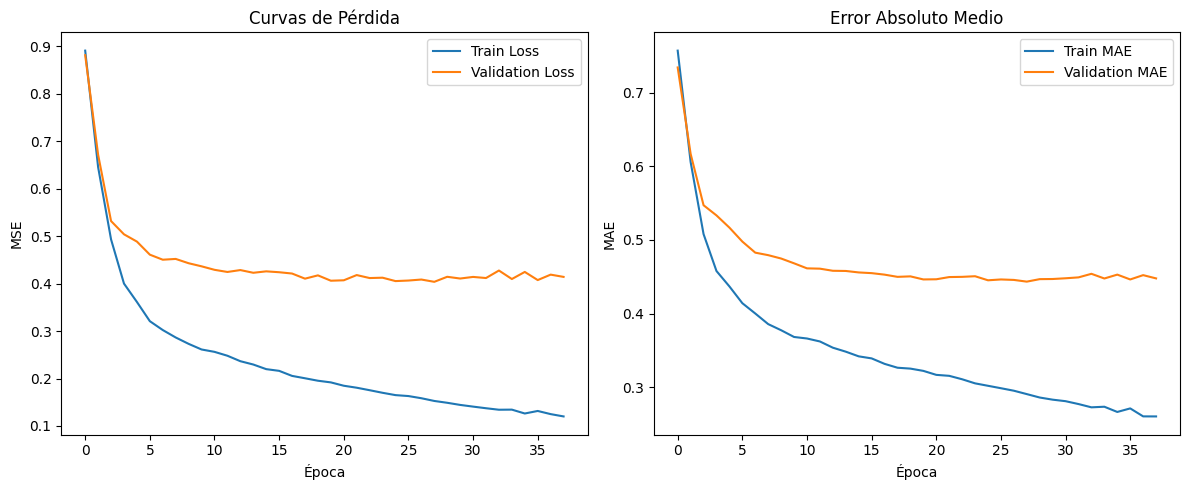

In [67]:
# Definir callbacks para monitoreo y early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Entrenar el modelo
history = model.fit(
    X_train_processed, y_train_scaled,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Visualizar el proceso de entrenamiento
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Curvas de Pérdida')
plt.xlabel('Época')
plt.ylabel('MSE')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Error Absoluto Medio')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()


### 4.3 Evaluación del Modelo

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
MSE: 1962722590720.00
RMSE: 1400972.02
MAE: 1032865.38
R²: 0.61


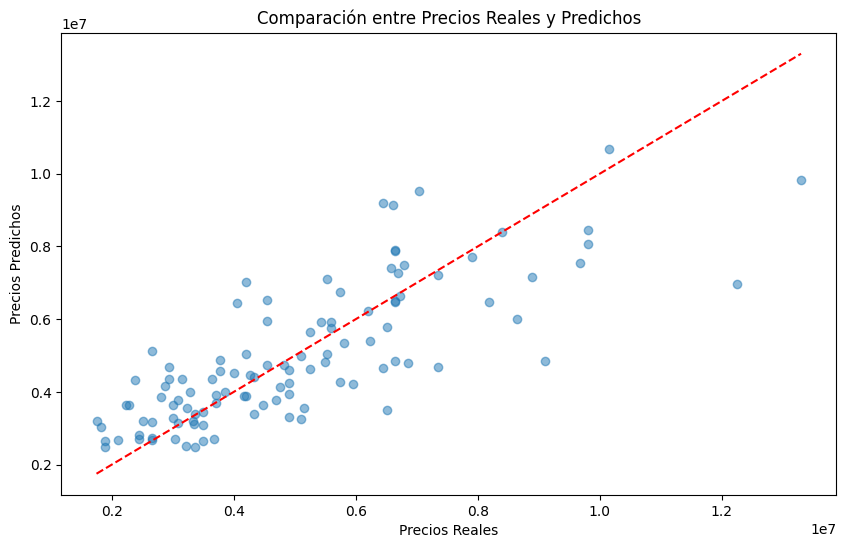

In [68]:
# Predicciones en conjunto de prueba
y_pred_scaled = model.predict(X_test_processed)

# Revertir la normalización para obtener predicciones en escala original
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_true = y_test.values.reshape(-1, 1)

# Calcular métricas de evaluación
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")

# Visualizar predicciones vs valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel('Precios Reales')
plt.ylabel('Precios Predichos')
plt.title('Comparación entre Precios Reales y Predichos')
plt.show()


## 5. Optimización del Modelo
### 5.1 Ajuste de Hiperparámetros 

In [69]:
# Definir un conjunto de hiperparámetros para probar
def build_model_with_hyperparams(neurons_layer1, neurons_layer2, learning_rate):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(neurons_layer1, activation='relu', input_shape=(num_features,)),
        tf.keras.layers.Dense(neurons_layer2, activation='relu'),
        tf.keras.layers.Dropout(0.2),  # Añadir regularización
        tf.keras.layers.Dense(1)
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=['mae']
    )
    
    return model

# Probar diferentes configuraciones
param_grid = [
    (128, 64, 0.001),
    (64, 32, 0.001),
    (32, 16, 0.001),
    (64, 32, 0.0001)
]

results = []

for params in param_grid:
    neurons_layer1, neurons_layer2, lr = params
    
    model = build_model_with_hyperparams(neurons_layer1, neurons_layer2, lr)
    
    history = model.fit(
        X_train_processed, y_train_scaled,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        verbose=0,
        callbacks=[early_stopping]
    )
    
    # Evaluar en conjunto de prueba
    val_loss = min(history.history['val_loss'])
    
    results.append({
        'params': params,
        'val_loss': val_loss
    })
    
    print(f"Parámetros: {params}, Val Loss: {val_loss:.4f}")

# Identificar mejor configuración
best_params = min(results, key=lambda x: x['val_loss'])['params']
print(f"Mejor configuración: {best_params}")


c:\Users\Alumno_AI\.conda\envs\house_model\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Parámetros: (128, 64, 0.001), Val Loss: 0.3972
Parámetros: (64, 32, 0.001), Val Loss: 0.3953
Parámetros: (32, 16, 0.001), Val Loss: 0.3522
Parámetros: (64, 32, 0.0001), Val Loss: 0.3928
Mejor configuración: (32, 16, 0.001)


### 5.2 Modelo Optimizado Final

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.1300 - mae: 0.8219 - val_loss: 1.0217 - val_mae: 0.8091
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8928 - mae: 0.7330 - val_loss: 0.7968 - val_mae: 0.7058
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7325 - mae: 0.6566 - val_loss: 0.6571 - val_mae: 0.6288
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6831 - mae: 0.6060 - val_loss: 0.5619 - val_mae: 0.5768
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4598 - mae: 0.5243 - val_loss: 0.5093 - val_mae: 0.5430
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4427 - mae: 0.5214 - val_loss: 0.4739 - val_mae: 0.5232
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4632 - mae: 0.5101 - val_loss: 0.4482 - val_mae: 0.5109
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4176 - mae: 0.4927 - val_loss: 0.4293 - val_mae: 0.4993
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.41

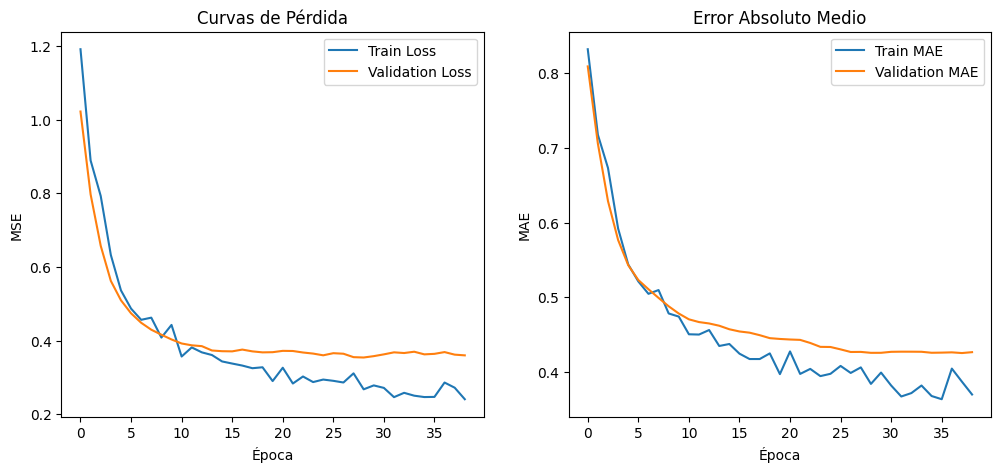

In [70]:
# Construir el modelo final con los mejores parámetros
neurons_layer1, neurons_layer2, lr = best_params

final_model = build_model_with_hyperparams(neurons_layer1, neurons_layer2, lr)

# Entrenar el modelo final
final_history = final_model.fit(
    X_train_processed, y_train_scaled,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Visualizar el proceso de entrenamiento
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(final_history.history['loss'], label='Train Loss')
plt.plot(final_history.history['val_loss'], label='Validation Loss')
plt.title('Curvas de Pérdida')
plt.xlabel('Época')
plt.ylabel('MSE')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(final_history.history['mae'], label='Train MAE')
plt.plot(final_history.history['val_mae'], label='Validation MAE')
plt.title('Error Absoluto Medio')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.legend()


# Evaluar el modelo final
y_pred_final_scaled = final_model.predict(X_test_processed)
y_pred_final = y_scaler.inverse_transform(y_pred_final_scaled)

# Calcular métricas finales
mse_final = mean_squared_error(y_true, y_pred_final)
rmse_final = np.sqrt(mse_final)
mae_final = mean_absolute_error(y_true, y_pred_final)
r2_final = r2_score(y_true, y_pred_final)



print(f"MSE Final: {mse_final:.2f}")
print(f"RMSE Final: {rmse_final:.2f}")
print(f"MAE Final: {mae_final:.2f}")
print(f"R² Final: {r2_final:.2f}")




14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Métricas en entrenamiento:
MSE: 758108651520.00
RMSE: 870694.35
RMSE (%): 18.50%
MAE: 640427.62
R²: 0.75


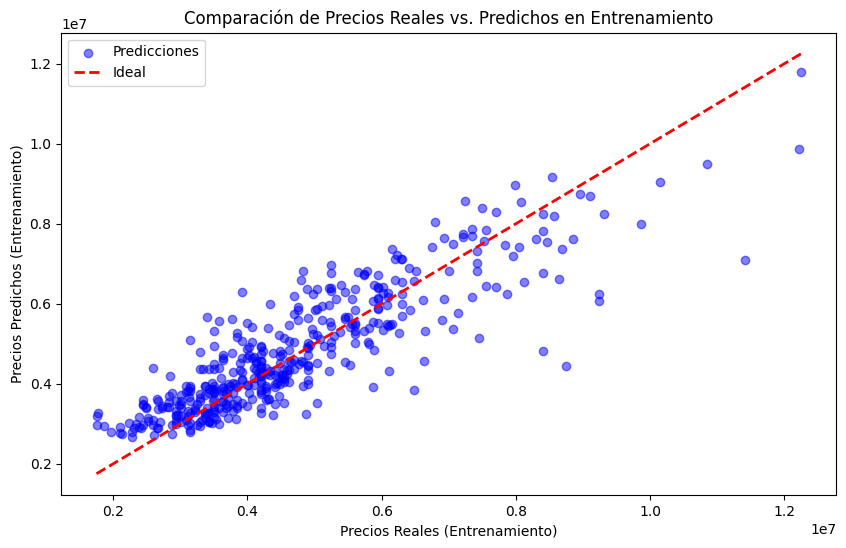

In [72]:
# Predicciones sobre el conjunto de entrenamiento
y_train_pred_scaled = final_model.predict(X_train_processed)
y_train_pred = y_scaler.inverse_transform(y_train_pred_scaled)
y_train_true = y_train.values.reshape(-1, 1)

# Calcular métricas en el conjunto de entrenamiento
mse_train = mean_squared_error(y_train_true, y_train_pred)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train_true, y_train_pred)
r2_train = r2_score(y_train_true, y_train_pred)
rmse_train_percent = (rmse_train / np.mean(y_train_true)) * 100

print(f"Métricas en entrenamiento:")
print(f"MSE: {mse_train:.2f}")
print(f"RMSE: {rmse_train:.2f}")
print(f"RMSE (%): {rmse_train_percent:.2f}%")
print(f"MAE: {mae_train:.2f}")
print(f"R²: {r2_train:.2f}")

# Visualizar predicciones vs. valores reales en entrenamiento
plt.figure(figsize=(10, 6))
plt.scatter(y_train_true, y_train_pred, alpha=0.5, color='blue', label='Predicciones')
plt.plot([y_train_true.min(), y_train_true.max()], [y_train_true.min(), y_train_true.max()], 'r--', lw=2, label='Ideal')
plt.xlabel('Precios Reales (Entrenamiento)')
plt.ylabel('Precios Predichos (Entrenamiento)')
plt.title('Comparación de Precios Reales vs. Predichos en Entrenamiento')
plt.legend()
plt.show()


### 5.3 Análisis de Características e Interpretabilidad

c:\Users\Alumno_AI\.conda\envs\house_model\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


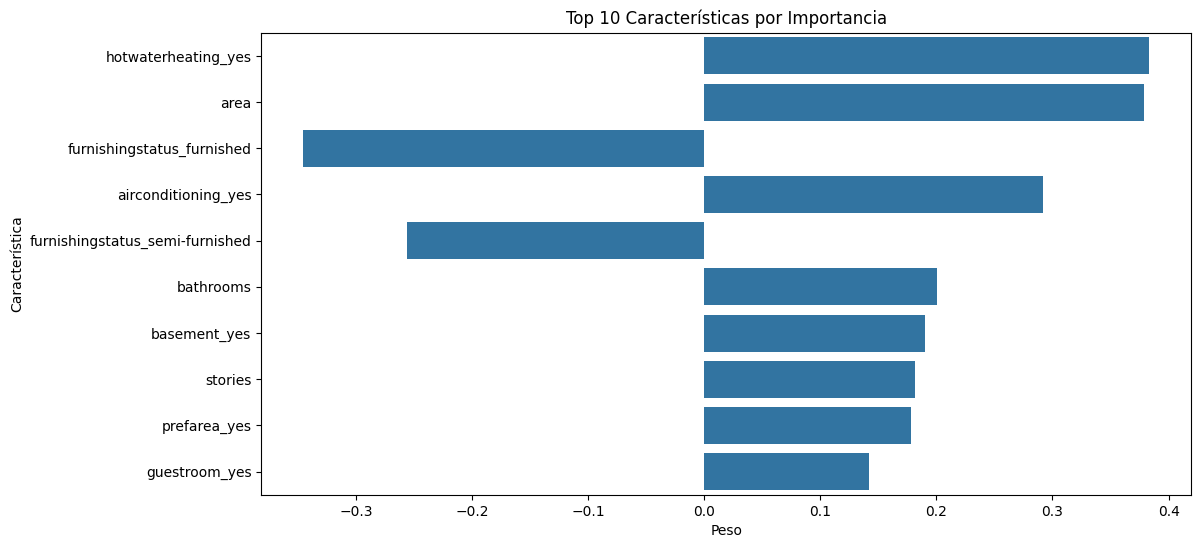

In [73]:
# Construir un modelo más simple para análisis de características
simple_model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=(num_features,), use_bias=False)
])

simple_model.compile(optimizer='adam', loss='mse')
simple_model.fit(X_train_processed, y_train_scaled, epochs=50, batch_size=32, verbose=0)

# Obtener los pesos del modelo
feature_weights = simple_model.get_weights()[0].flatten()

# Obtener nombres de características después del preprocesamiento
feature_names = []
for name, transformer, features in preprocessor.transformers_:
    if name == 'num':
        feature_names.extend(features)
    elif name == 'cat':
        for feature in features:
            feature_names.extend([f"{feature}_yes"])
    elif name == 'ord':
        for feature in features:
            feature_names.extend([f"{feature}_{category}" for category in ['unfurnished', 'semi-furnished', 'furnished']])

# Crear DataFrame para visualización
importance_df = pd.DataFrame({
    'Feature': feature_names[:len(feature_weights)],
    'Weight': feature_weights
})

# Ordenar por valor absoluto del peso
importance_df['AbsWeight'] = importance_df['Weight'].abs()
importance_df = importance_df.sort_values('AbsWeight', ascending=False).head(10)

# Visualizar importancia de características
plt.figure(figsize=(12, 6))
sns.barplot(x='Weight', y='Feature', data=importance_df)
plt.title('Top 10 Características por Importancia')
plt.xlabel('Peso')
plt.ylabel('Característica')
plt.show()


### 5.4 Implementación para Predicciones

In [74]:
# Función para procesar nuevos datos y hacer predicciones
def predict_house_price(new_data, preprocessor, model, y_scaler):
    """
    Predice el precio de una casa con nuevos datos.
    
    Args:
        new_data: DataFrame con los datos de una nueva casa
        preprocessor: ColumnTransformer para procesar los datos
        model: Modelo entrenado
        y_scaler: Scaler usado para normalizar y desnormalizar
    
    Returns:
        Precio predicho de la casa
    """
    # Procesar nuevos datos
    new_data_processed = preprocessor.transform(new_data)
    
    # Predecir
    prediction_scaled = model.predict(new_data_processed)
    
    # Desnormalizar
    prediction = y_scaler.inverse_transform(prediction_scaled)
    
    return prediction[0][0]

# Ejemplo de uso con una nueva casa
new_house = pd.DataFrame({
    'area': [5000],
    'bedrooms': [3],
    'bathrooms': [2],
    'stories': [2],
    'mainroad': ['yes'],
    'guestroom': ['no'],
    'basement': ['yes'],
    'hotwaterheating': ['no'],
    'airconditioning': ['yes'],
    'parking': [1],
    'prefarea': ['yes'],
    'furnishingstatus': ['furnished']
})

predicted_price = predict_house_price(new_house, preprocessor, final_model, y_scaler)
print(f"Precio predicho para la nueva casa: {predicted_price:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Precio predicho para la nueva casa: 7241700.00


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
   Precio Real  Precio Predicho
0      4060000       5211137.00
1      6650000       7063191.50
2      3710000       3444726.50
3      6440000       4727967.00
4      2800000       3630072.25


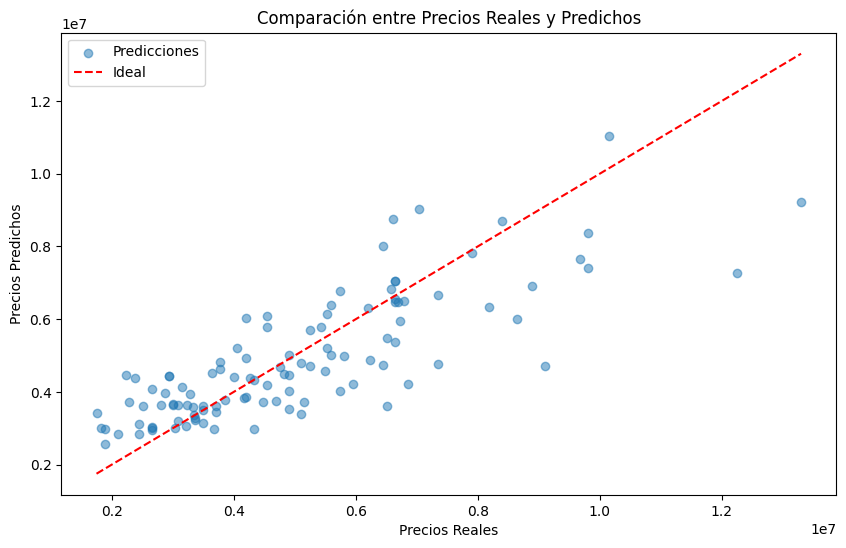

In [77]:
y_pred_scaled = final_model.predict(X_test_processed)
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_true = y_test.values.reshape(-1, 1)


import pandas as pd

df_comparativa = pd.DataFrame({
    'Precio Real': y_true.flatten(),
    'Precio Predicho': y_pred.flatten()
})

print(df_comparativa.head())

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, alpha=0.5, label='Predicciones')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', label='Ideal')
plt.xlabel('Precios Reales')
plt.ylabel('Precios Predichos')
plt.title('Comparación entre Precios Reales y Predichos')
plt.legend()
plt.show()


## 6. Evaluacion, Guardado y carga del modelo
### 6.1 Guardado

In [57]:
# Guardar el modelo
tf.saved_model.save(model, 'house_price_model_saved_model')

# Cargar el modelo
loaded_model = tf.saved_model.load('house_price_model_saved_model')

# Para hacer predicciones, necesitas obtener la función de inferencia del modelo cargado
infer = loaded_model.signatures["serving_default"]


INFO:tensorflow:Assets written to: house_price_model_saved_model\assets


INFO:tensorflow:Assets written to: house_price_model_saved_model\assets


### 6.2 Validación Cruzada para Evaluación Robusta

In [58]:
from sklearn.model_selection import KFold

# Configurar validación cruzada
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

cv_scores = []

# Función para crear y entrenar modelo
def create_and_train_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(num_features,)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Realizar validación cruzada
print("Iniciando validación cruzada...")
fold = 1

X_processed = preprocessor.fit_transform(X)
y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

for train_idx, test_idx in kf.split(X_processed):
    X_train_fold, X_test_fold = X_processed[train_idx], X_processed[test_idx]
    y_train_fold, y_test_fold = y_scaled[train_idx], y_scaled[test_idx]
    
    # Crear y entrenar modelo
    fold_model = create_and_train_model()
    fold_model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=32, verbose=0)
    
    # Evaluar
    y_pred_fold = fold_model.predict(X_test_fold)
    mse_fold = mean_squared_error(y_test_fold, y_pred_fold)
    
    cv_scores.append(mse_fold)
    print(f"Fold {fold}: MSE = {mse_fold:.4f}")
    fold += 1

print(f"Promedio MSE en validación cruzada: {np.mean(cv_scores):.4f}")
print(f"Desviación estándar: {np.std(cv_scores):.4f}")


Iniciando validación cruzada...


c:\Users\Alumno_AI\.conda\envs\house_model\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Fold 1: MSE = 0.5387


c:\Users\Alumno_AI\.conda\envs\house_model\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Fold 2: MSE = 0.4054


c:\Users\Alumno_AI\.conda\envs\house_model\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Fold 3: MSE = 0.2779


c:\Users\Alumno_AI\.conda\envs\house_model\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Fold 4: MSE = 0.3214


c:\Users\Alumno_AI\.conda\envs\house_model\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Fold 5: MSE = 0.3307
Promedio MSE en validación cruzada: 0.3748
Desviación estándar: 0.0916


### 6.3 Carga

In [59]:
import tensorflow as tf

# Cargar el modelo
loaded_model = tf.saved_model.load('house_price_model_saved_model')

# Imprimir las firmas del modelo
print(loaded_model.signatures)


_SignatureMap({'serving_default': <ConcreteFunction (*, inputs: TensorSpec(shape=(None, 14), dtype=tf.float32, name='inputs')) -> Dict[['output_0', TensorSpec(shape=(None, 1), dtype=tf.float32, name='output_0')]] at 0x26E396DEC50>})


In [60]:
print(loaded_model.signatures['serving_default'].structured_outputs)


{'output_0': TensorSpec(shape=(None, 1), dtype=tf.float32, name='output_0')}


## 7. Inferencia

In [61]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import pickle
import pandas as pd

# Paso 7: Cargar el modelo usando tf.saved_model
loaded_model = tf.saved_model.load('house_price_model_saved_model')

# Paso 8: Cargar el scaler
with open('scaler.pkl', 'rb') as f:
    loaded_scaler = pickle.load(f)

# Paso 9: Preparar nuevos datos para la predicción
new_data = pd.DataFrame({
    'area': [7420],
    'bedrooms': [4],
    'bathrooms': [2],
    'stories': [3],
    'mainroad': [1],
    'guestroom': [0],
    'basement': [0],
    'hotwaterheating': [0],
    'airconditioning': [1],
    'parking': [2],
    'prefarea': [1],
    'furnishingstatus_semi-furnished': [0],
    'furnishingstatus_unfurnished': [0]
})

# Paso 10: Escalar los nuevos datos
new_data_scaled = loaded_scaler.transform(new_data)

# Paso 11: Obtener la función de inferencia del modelo cargado
infer = loaded_model.signatures["serving_default"]

# Paso 12: Realizar la predicción
prediction = infer(tf.constant(new_data_scaled, dtype=tf.float32))

# Ajusta el nombre de la capa aquí
nombre_capa_salida = list(prediction.keys())[0]  # Obtener el primer nombre de clave
print(nombre_capa_salida)

# Ajusta el nombre de la capa aquí
print(f"Predicción del precio de la vivienda: {prediction[nombre_capa_salida].numpy()[0][0]:.2f}")


InvalidArgumentError: Graph execution error:

Detected at node StatefulPartitionedCall/sequential_22_1/dense_66_1/Relu defined at (most recent call last):
<stack traces unavailable>
Matrix size-incompatible: In[0]: [1,13], In[1]: [14,64]
	 [[{{node StatefulPartitionedCall/sequential_22_1/dense_66_1/Relu}}]] [Op:__inference_signature_wrapper_serving_default_170577]